<a href="https://colab.research.google.com/github/Archii0/sentiment-trading/blob/main/SentimentTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Sentiment Investing Strategy

### Load Twitter Sentiment Data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = '/content'

sentiment_df = pd.read_csv(os.path.join(data_folder, "sentiment_data.csv"))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# set indexes to format data frame
sentiment_df = sentiment_df.set_index(['date', 'symbol'])

# calculate an engagement ratio, an attempt to avoid bot activity
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']

# filter out stocks with low overall engagement
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (sentiment_df['twitterComments'] > 10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2022-09-12 AAPL          6944.0          24634.0      137990.0   
           ABBV           184.0           2311.0       13389.0   
           ABT             71.0            110.0         167.0   
           AEP             31.0             16.0         106.0   
           AES             24.0             28.0         342.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2022-09-12 AAPL            50798362.0          0.569925          0.178520  
           ABBV              589294.0          0.604417          0.172604  
           ABT               426196.0          0.533320          0.658683  
           AEP               149776.0          0.534107          0.150943  
           AES               108504.0          0.530082          0.081871  

[17109 rows x 6 columns]

## Aggregate monthly and calculate average sentiment for the month

In [2]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2022-09-30 TMO             0.262058  36.0
           TSLA            0.180972  72.0
           TSN             0.290067  29.0
           V               0.236302  43.0
           XOM             0.198669  63.0

[787 rows x 2 columns]

## Select top 5 stocks for each month based on their cross-sectional ranking

In [3]:
# filter out the top 5
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

# add a one month offset
filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

## Extract the stocks to form porfolios with at the start of each new month

In [4]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['FCX', 'J', 'L', 'META', 'MU']}

## Download fresh stock prices for only selected stocks

In [5]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  85 of 85 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


## Calculate portfolio returns with monthly rebalancing

In [12]:
returns_df = np.log(prices_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

  cols = fixed_dates[start_date]

  temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

  portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df


,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2022-10-25,0.017090
2022-10-26,-0.000326
2022-10-27,-0.069519


Download NASDAQ prices and calculate returns to compare to sentiment strategy

In [13]:
qqq_df = yf.download(tickers='QQQ',
                        start='2021-01-01',
                        end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2022-10-25,0.017090,0.020475
2022-10-26,-0.000326,-0.022344
2022-10-27,-0.069519,-0.018374


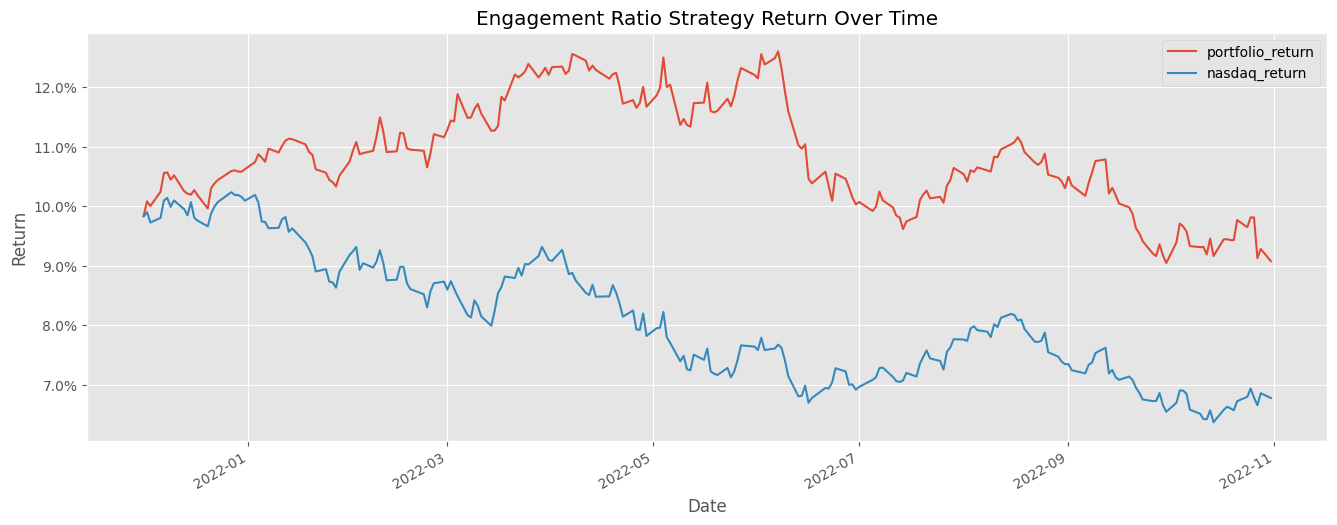

In [14]:
import matplotlib.ticker as mtick

portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())

portfolios_cumulative_return.plot(figsize=(16, 6))

plt.title('Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(10))

plt.ylabel('Return')

plt.show()